<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.8 MB/s eta 0:00:00


In [3]:
import math
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn
import mplfinance as mpf
import matplotlib as mpl# 用于设置曲线参数
from cycler import cycler# 用于定制线条颜色

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

[*********************100%***********************]  1 of 1 completed


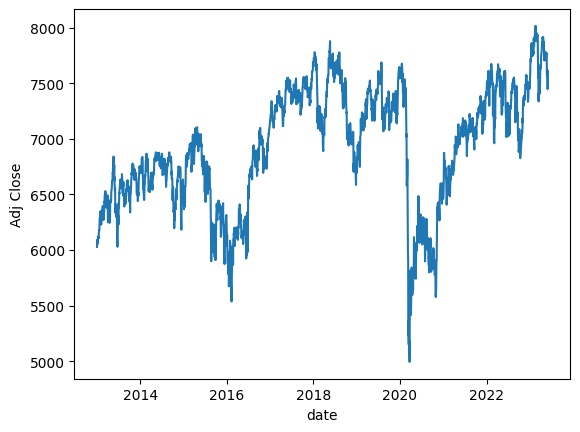

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,5897.799805,6044.600098,5897.799805,6027.399902,6027.399902,652659400
2013-01-03,6027.399902,6051.299805,6016.799805,6047.299805,6047.299805,470665900
2013-01-04,6047.299805,6089.799805,6038.000000,6089.799805,6089.799805,548929200
2013-01-07,6089.799805,6091.500000,6060.799805,6064.600098,6064.600098,571661700
2013-01-08,6064.600098,6088.200195,6053.600098,6053.600098,6053.600098,663115700
...,...,...,...,...,...,...
2023-05-26,7570.899902,7643.600098,7556.899902,7627.200195,7627.200195,817609400
2023-05-30,7627.200195,7628.100098,7516.500000,7522.100098,7522.100098,856682400
2023-05-31,7522.100098,7522.100098,7446.100098,7446.100098,7446.100098,2295618500


In [13]:
# Parameter for data
## Security code
stock_code='^FTSE'
# Start Date
start_date='2013-01-01'
## End Date
end_date='2023-06-03'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
observation_period_num=3
## How many business days to predict
predict_period_num=1

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=100
## Mini-Batch size
batch_size=64
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)

# Plot 'Adj Close' values
plt.plot(df.iloc[:,-2])
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

df

In [14]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,-1.922509,-1.745696,-1.820793,-1.680650,-1.680650,-0.513567
2013-01-03,-1.678833,-1.732926,-1.600127,-1.643220,-1.643220,-1.211452
2013-01-04,-1.641417,-1.659543,-1.560814,-1.563280,-1.563280,-0.911338
2013-01-07,-1.561507,-1.656303,-1.518536,-1.610679,-1.610679,-0.824166
2013-01-08,-1.608888,-1.662592,-1.531886,-1.631369,-1.631369,-0.473470
...,...,...,...,...,...,...
2023-05-26,1.223284,1.302072,1.255744,1.328464,1.328464,0.118962
2023-05-30,1.329141,1.272529,1.180828,1.130778,1.130778,0.268794
2023-05-31,1.131530,1.070488,1.050283,0.987827,0.987827,5.786641


In [15]:
def calculate_change_pct(data):
  data['close_pct'] = (data["Adj Close"] - data["Adj Close"].shift(1)) / data["Adj Close"].shift(1)
  return data
df = calculate_change_pct(df)
df = df.fillna(0)
df


,Open,High,Low,Close,Adj Close,Volume,close_pct
Date,,,,,,,
2013-01-02,-1.922509,-1.745696,-1.820793,-1.680650,-1.680650,-0.513567,0.000000
2013-01-03,-1.678833,-1.732926,-1.600127,-1.643220,-1.643220,-1.211452,-0.022271
2013-01-04,-1.641417,-1.659543,-1.560814,-1.563280,-1.563280,-0.911338,-0.048648
2013-01-07,-1.561507,-1.656303,-1.518536,-1.610679,-1.610679,-0.824166,0.030320
2013-01-08,-1.608888,-1.662592,-1.531886,-1.631369,-1.631369,-0.473470,0.012846
...,...,...,...,...,...,...,...
2023-05-26,1.223284,1.302072,1.255744,1.328464,1.328464,0.118962,0.086619
2023-05-30,1.329141,1.272529,1.180828,1.130778,1.130778,0.268794,-0.148808
2023-05-31,1.131530,1.070488,1.050283,0.987827,0.987827,5.786641,-0.126418


In [16]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,4].values
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,-1].values
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])
inout_data

train data： 2100
valid data： 526


tensor([[[-1.6806, -1.6432, -1.5633],
         [-0.0223, -0.0486,  0.0303]],

        [[-1.6432, -1.5633, -1.6107],
         [-0.0486,  0.0303,  0.0128]],

        [[-1.5633, -1.6107, -1.6314],
         [ 0.0303,  0.0128, -0.0520]],

        ...,

        [[ 1.3283,  1.2226,  1.3285],
         [-0.0796,  0.0866, -0.1488]],

        [[ 1.2226,  1.3285,  1.1308],
         [ 0.0866, -0.1488, -0.1264]],

        [[ 1.3285,  1.1308,  0.9878],
         [-0.1488, -0.1264,  0.0842]]])

In [17]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
  seq_len=min(batch_size, len(source)-1-i)
  data=source[i:i+seq_len]
  input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
  target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

  return input, target

In [18]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)

  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [19]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=10,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size,1)

  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [20]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf

    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score==self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

 10:epoch | 0.4822865 : train loss | 6.937013 : valid loss
 20:epoch | 0.4816441 : train loss | 6.920555 : valid loss
 30:epoch | 0.480675 : train loss | 6.929803 : valid loss
 40:epoch | 0.4808358 : train loss | 6.937105 : valid loss
 50:epoch | 0.4809099 : train loss | 6.945986 : valid loss
 60:epoch | 0.4801232 : train loss | 6.946535 : valid loss
 70:epoch | 0.4804013 : train loss | 6.956721 : valid loss
 80:epoch | 0.4806949 : train loss | 6.9582 : valid loss
 90:epoch | 0.4803138 : train loss | 6.962688 : valid loss
100:epoch | 0.4802365 : train loss | 6.963695 : valid loss


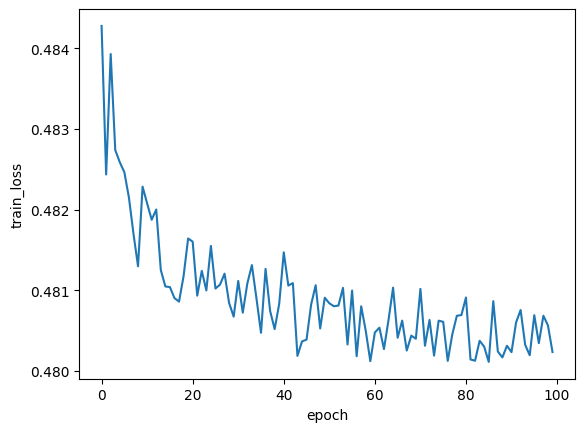

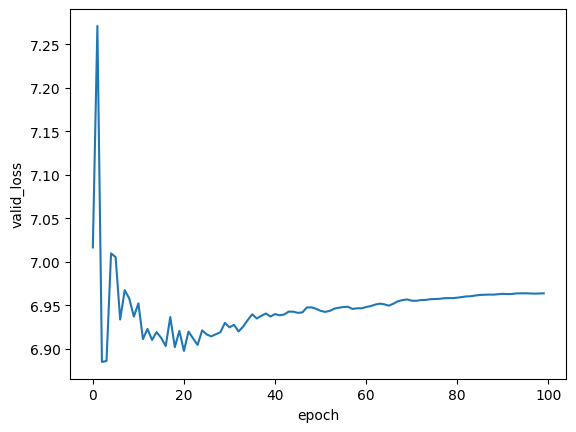

In [21]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data),batch_size)):
    data,targets=get_batch(train_data,i,batch_size)
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data)

  #valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data),batch_size):
    data,targets=get_batch(valid_data,i,batch_size)
    output=model(data)
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

In [25]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data)-1):
    data,target=get_batch(valid_data,i,1)
    output=model(data)
    result=torch.cat((result,output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)



tensor([ 7.7659e-01, -5.1430e-02,  2.0453e-01, -9.5335e-01,  5.0918e+01,
         3.1171e-01,  3.4454e-01, -2.8738e-02, -8.6646e-01,  2.0901e+00,
        -4.9355e-01,  1.8948e+00, -8.7220e-02,  1.1612e-02, -7.4152e-01,
         2.3770e+00, -1.7190e-02,  3.4472e-01, -1.6682e-01, -2.6634e-02,
        -6.7935e-02,  2.9357e-02,  5.6943e-01,  1.7233e-01, -2.3306e-01,
         3.2061e-02,  5.5377e-02,  1.1454e-01, -8.0951e-02,  4.4979e-02,
         2.7439e-01,  5.9105e-02,  1.1427e-01,  4.9686e-02, -1.1966e-01,
        -5.8457e-01,  4.6386e-01,  1.9593e-01, -9.4038e-02,  2.3436e-01,
         1.3804e-01, -2.9324e-01,  9.6003e-02, -3.0058e-01,  7.5228e-01,
        -9.3029e-03,  2.0555e-01, -2.6232e-01,  2.7837e-01, -5.2286e-01,
         8.3075e-01,  1.7415e-02, -3.4219e-03, -1.6439e-01, -4.6512e-01,
        -4.2818e-02, -1.8777e+00, -4.7961e-01, -2.9432e+00, -3.8770e-01,
         1.2516e+00, -2.0624e-02, -2.8044e-01,  2.7268e-01,  6.4590e-01,
        -2.9274e-01,  4.4353e-01,  1.4927e-01,  9.8

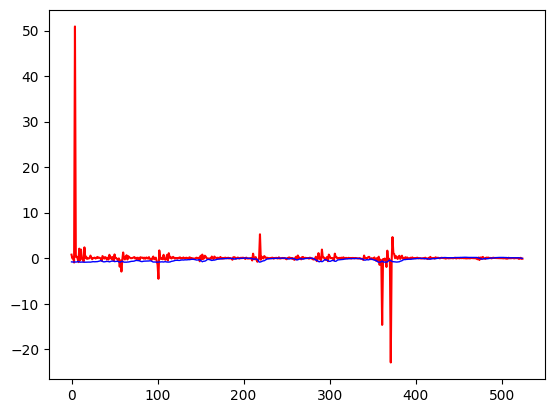

In [33]:
re = np.array(result)
re
results = pd.DataFrame(re)
results
re_pct= results.pct_change(periods=1)
re_pct

plt.plot(actual,color='red',alpha=1.0)
plt.plot(results,color='blue',linewidth=1.0)
plt.show()

In [ ]:
def draw_Kline(df,period,symbol):
    # 设置基本参数
    # type:绘制图形的类型，有candle, renko, ohlc, line等
    # 此处选择candle,即K线图
    # mav(moving average):均线类型,此处设置7,30,60日线
    # volume:布尔类型，设置是否显示成交量，默认False
    # title:设置标题
    # y_label:设置纵轴主标题
    # y_label_lower:设置成交量图一栏的标题
    # figratio:设置图形纵横比
    # figscale:设置图形尺寸(数值越大图像质量越高)
    kwargs = dict(
        type='candle',
        mav=(7, 30, 60),
        volume=True,
        title='\nA_stock %s candle_line' % (symbol),
        ylabel='OHLC Candles',
        ylabel_lower='Shares\nTraded Volume',
        figratio=(15, 10),
        figscale=2)

    # 设置marketcolors
    # up:设置K线线柱颜色，up意为收盘价大于等于开盘价
    # down:与up相反，这样设置与国内K线颜色标准相符
    # edge:K线线柱边缘颜色(i代表继承自up和down的颜色)，下同。详见官方文档)
    # wick:灯芯(上下影线)颜色
    # volume:成交量直方图的颜色
    # inherit:是否继承，选填
    mc = mpf.make_marketcolors(
        up='red',
        down='green',
        edge='i',
        wick='i',
        volume='in',
        inherit=True)

    # 设置图形风格
    # gridaxis:设置网格线位置
    # gridstyle:设置网格线线型
    # y_on_right:设置y轴位置是否在右
    s = mpf.make_mpf_style(
        gridaxis='both',
        gridstyle='-.',
        y_on_right=False,
        marketcolors=mc)

    # 设置均线颜色，配色表可见下图
    # 建议设置较深的颜色且与红色、绿色形成对比
    # 此处设置七条均线的颜色，也可应用默认设置
    mpl.rcParams['axes.prop_cycle'] = cycler(
        color=['dodgerblue', 'deeppink',
        'navy', 'teal', 'maroon', 'darkorange',
        'indigo'])

    # 设置线宽
    mpl.rcParams['lines.linewidth'] = .5

    # 图形绘制
    # show_nontrading:是否显示非交易日，默认False
    # savefig:导出图片，填写文件名及后缀
    mpf.plot(df,
        **kwargs,
        style=s,
        show_nontrading=False,)
    mpf.plot(df,
        **kwargs,
        style=s,
        show_nontrading=False,
        savefig='A_stock-%s %s_candle_line'
        %(symbol, period) + '.jpg')
    plt.show()

In [ ]:
def data_wash(dataset,keepTime=False):
    if keepTime:
        dataset.fillna(axis=1,method='ffill')
    else:
        dataset.dropna()
    return dataset

In [ ]:
def import_csv(stock_code):
    #time设为index的同时是否保留时间列
    df = wb.DataReader(stock_code,start=start_date,end=end_date)
    #清洗数据
    df=data_wash(df,keepTime=False)
    return df

[*********************100%***********************]  1 of 1 completed


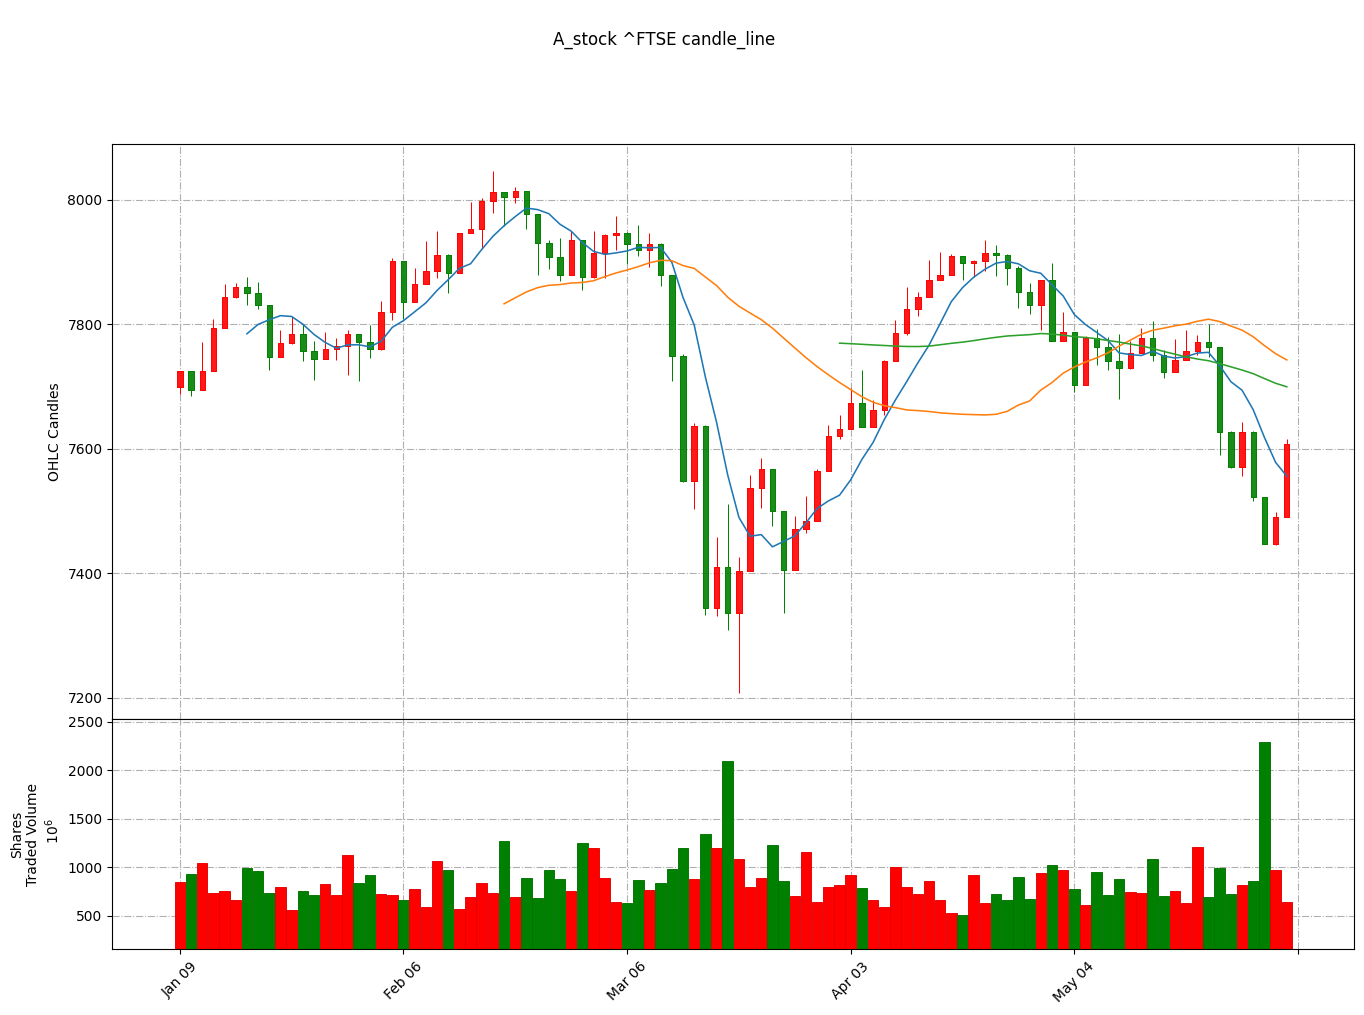

In [ ]:
if __name__=="__main__":
    symbol = '^FTSE'
    period = 100
    data = import_csv(symbol)
    df_draw=data[-period:]
    draw_Kline(df_draw,period,symbol)